In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import plotly.express as px
warnings.simplefilter('ignore')

from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.corpus import stopwords

%matplotlib inline

In [ ]:
df = pd.read_excel('/content/orders_data.xlsx')

In [ ]:
def drop(df, *features):
    for i in features:
        df.drop(i, axis=1, inplace=True)

In [ ]:
places = ['ship_city', 'ship_state']
for i in places:
    df[i] = df[i].apply(lambda x: x.upper())

In [ ]:
# removing comma from city values
df['ship_city'] = df['ship_city'].apply(lambda x: x.replace(',', ''))
df['ship_state'] = df['ship_state'].apply(lambda x: x.replace(',', ''))

In [ ]:
# imputing with mode as shipping fee is fixed based on package size and weight
df['shipping_fee'].fillna(df['shipping_fee'].mode()[0], inplace=True)

# imputing with mode as we are considering the item that is sold the most
df['item_total'].fillna(df['item_total'].mode()[0], inplace=True)

# assuming if an order is not cod would mean the mode of payment is online
df['cod'].fillna('online', inplace=True)

In [ ]:
# remove rupee symbol from amount features
amounts = ['item_total', 'shipping_fee']
for i in amounts:
    df[i] = df[i].apply(lambda x: x.replace(',', ''))        # remove the commas in amounts greater than 1000
    df[i] = df[i].apply(lambda x: x[1:])

In [ ]:
# change data types
i = 'int64'
f = 'float64'
df = df.astype({'item_total': f, 'shipping_fee': f, 'quantity': i})

In [ ]:
df[['cod', 'order_status', 'item_total']].groupby(['cod', 'order_status']).sum().reset_index()

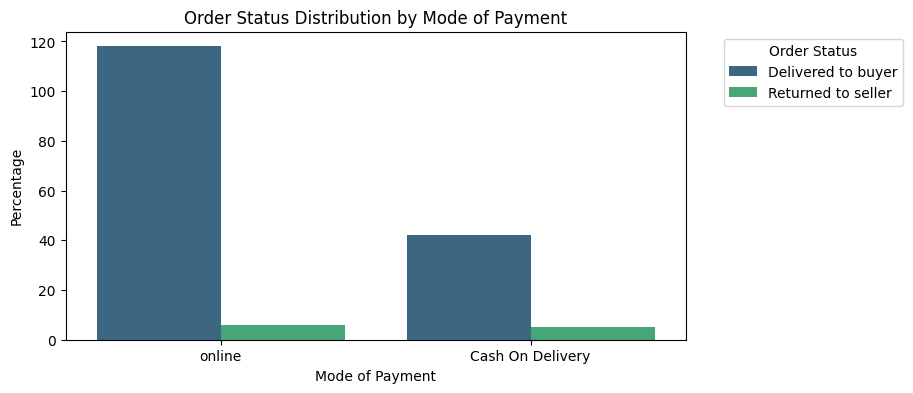

In [ ]:
plt.figure(figsize = (8,4))
sns.countplot(x='cod', hue='order_status', data=df, palette='viridis', dodge=True)
plt.title('Order Status Distribution by Mode of Payment')
plt.xlabel('Mode of Payment')
plt.ylabel('Percentage')
plt.legend(title='Order Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

We see that most of the orders were prepaid and the percentage of return orders is more in cod mode.

In [ ]:
# extract year, month, day and time from date feature
df['year'] = pd.DatetimeIndex(df['order_date']).year
df['date'] = pd.DatetimeIndex(df['order_date']).date
df['time'] = pd.DatetimeIndex(df['order_date']).time
df['month_name'] = pd.DatetimeIndex(df['date']).month_name()
df['day_name'] = pd.DatetimeIndex(df['date']).day_name()

In [ ]:
drop(df, 'order_date')
df.head(2)


In [ ]:
# Extracting the unique identifier
df['sku'] = df['sku'].apply(lambda x: x[4:])
df.head(2)

In [ ]:
df_sales = df[['date', 'item_total']].groupby('date').sum().reset_index()
df_sales.head(3)

In [ ]:
# Create a line plot with Plotly Express
plt.figure(figsize = (4,4))
fig = px.line(df_sales, x='date', y='item_total', title='Sales Trend Over Time')

# Customize the appearance of the plot
fig.update_traces(marker=dict(color='blue', size=8),
                  line=dict(color='blue', width=2),
                  mode='lines+markers')

# Customize layout
fig.update_layout(xaxis_title='Date', yaxis_title='Sales Amount', showlegend=True)

# Show the modified plot
fig.show()

<Figure size 400x400 with 0 Axes>

There hasn't been any significant growth over the period. December month saw the maximum sales with a couple of breakthroughs.

In [ ]:
df_days = df[['year', 'month_name', 'day_name', 'item_total']].groupby(['year', 'month_name', 'day_name']).sum().reset_index()
# df_days.sort_values(by=['year', 'month_name'])

In [ ]:
fig = px.bar(df_days, x="month_name", y="item_total", color="day_name",
             title="Month-wise Sales by Day of the Week",
             labels={'item_total': 'Total Sales Amount', 'month_name': 'Month'})

# Customize layout
fig.update_layout(barmode='group', xaxis_title='Month', yaxis_title='Total Sales Amount')

# Show the modified plot
fig.show()

In [ ]:
df_places = df_places.groupby(['ship_state', 'ship_city'])['item_total'].sum().reset_index()

# Sort the DataFrame by item_total in descending order
df_places.sort_values(by='item_total', ascending=False, inplace=True)

# Extract the top states with the highest total sales
top_states = df_places.groupby('ship_state')['item_total'].sum().reset_index()
top_states.sort_values(by='item_total', ascending=False, inplace=True)

# Display the results
for index, row in top_states.iterrows():
    print(f"State: {row['ship_state']}, Total Sales: {row['item_total']}")

State: MAHARASHTRA, Total Sales: 18064.0
State: WEST BENGAL, Total Sales: 14184.0
State: TAMIL NADU, Total Sales: 11634.0
State: KARNATAKA, Total Sales: 7934.0
State: UTTAR PRADESH, Total Sales: 6038.0
State: TELANGANA, Total Sales: 5563.0
State: HARYANA, Total Sales: 4390.0
State: CHHATTISGARH, Total Sales: 3994.0
State: GUJARAT, Total Sales: 3845.0
State: DELHI, Total Sales: 3642.0
State: ASSAM, Total Sales: 2447.0
State: RAJASTHAN, Total Sales: 2197.0
State: KERALA, Total Sales: 2197.0
State: CHANDIGARH, Total Sales: 1822.0
State: ODISHA, Total Sales: 1547.0
State: ANDHRA PRADESH, Total Sales: 1523.0
State: UTTARAKHAND, Total Sales: 1299.0
State: ARUNACHAL PRADESH, Total Sales: 898.0
State: GOA, Total Sales: 898.0
State: BIHAR, Total Sales: 549.0
State: MADHYA PRADESH, Total Sales: 449.0
State: MOHALI, Total Sales: 449.0
State: PUNJAB, Total Sales: 449.0
State: TRIPURA, Total Sales: 449.0
State: JAMMU & KASHMIR, Total Sales: 399.0
State: HIMACHAL PRADESH, Total Sales: 399.0


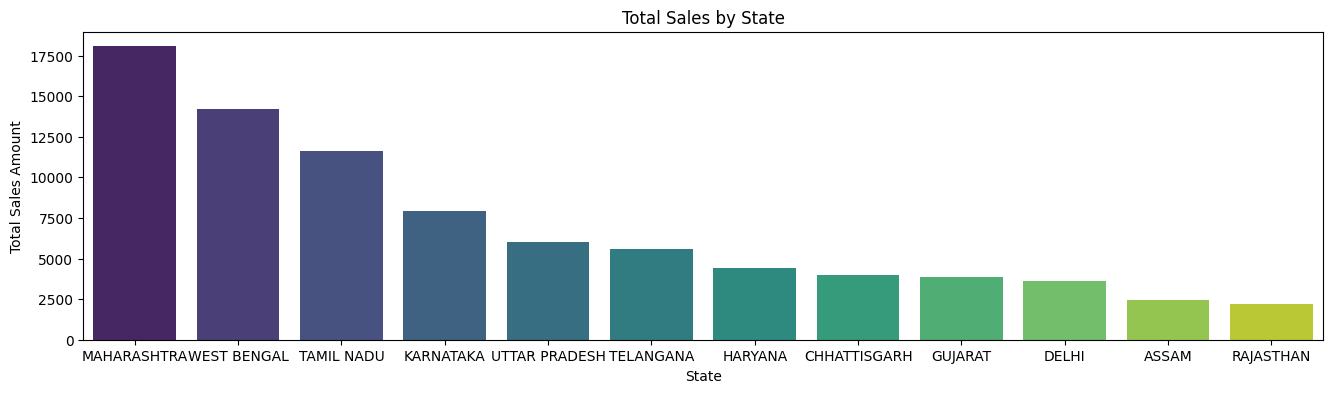

In [ ]:
top_states = top_states.head(12)
plt.figure(figsize=(16, 4))
sns.barplot(x='ship_state', y='item_total', data=top_states, palette='viridis')
plt.title('Total Sales by State')
plt.xlabel('State')
plt.ylabel('Total Sales Amount')
plt.show()

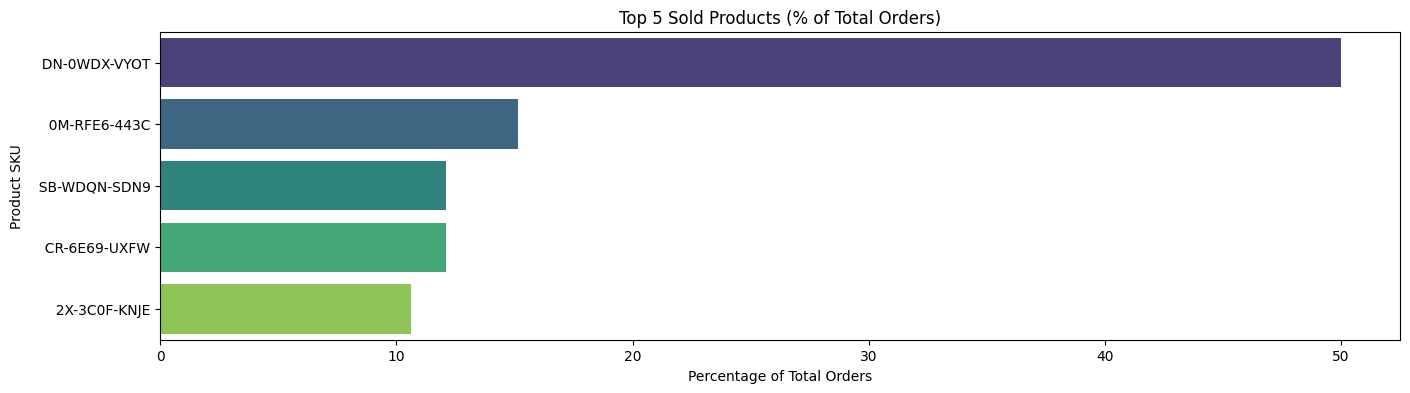

In [ ]:
# Get the top 5 sold products
top_products = df.groupby('sku').size().reset_index().rename(columns={0: 'Total'}).sort_values('Total', ascending=False).head()

# Calculate the percentage of total orders for each product
top_products['Percentage'] = (top_products['Total'] / top_products['Total'].sum()) * 100

# Create a bar chart for the top sold products in percentage
plt.figure(figsize=(16, 4))
sns.barplot(x='Percentage', y='sku', data=top_products, palette='viridis')
plt.title('Top 5 Sold Products (% of Total Orders)')
plt.xlabel('Percentage of Total Orders')
plt.ylabel('Product SKU')
plt.show()
# DN-0WDX-VYOT,0M-RFE6-443C, SB-WDQN-SDN9, CR-6E69-UXFW, 2X-3C0F-KNJE


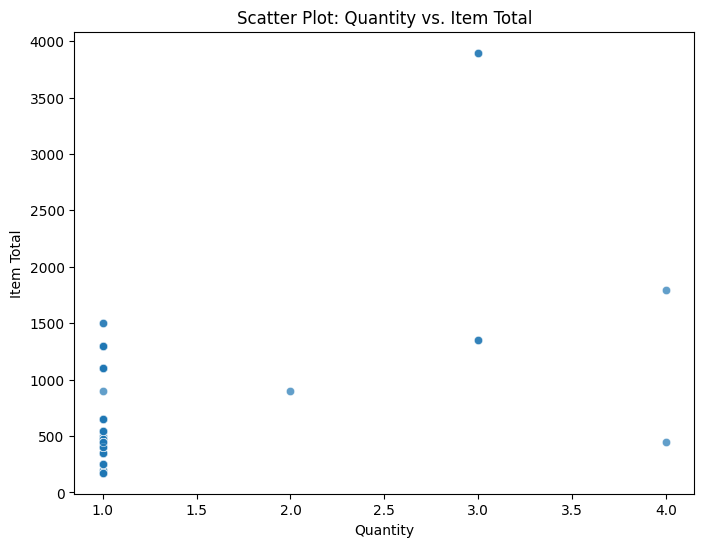

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='quantity', y='item_total', data=df, alpha=0.7)
plt.title('Scatter Plot: Quantity vs. Item Total')
plt.xlabel('Quantity')
plt.ylabel('Item Total')
plt.show()


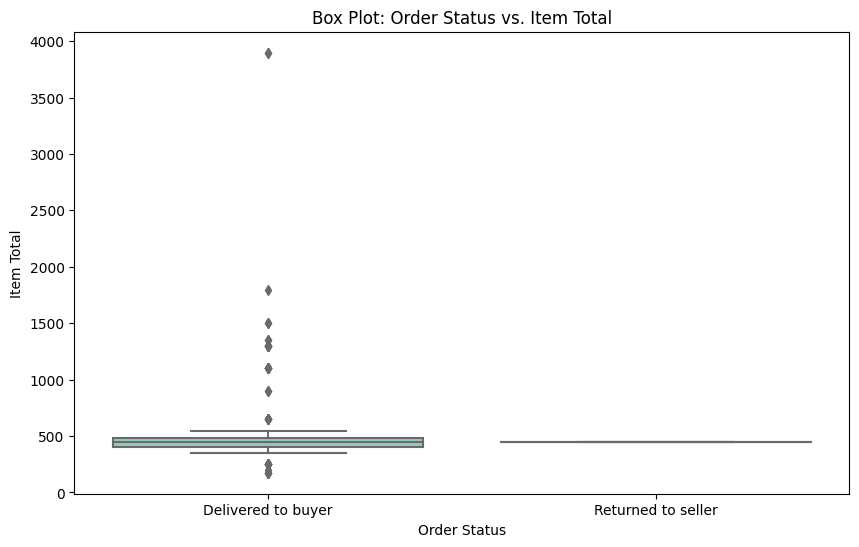

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='order_status', y='item_total', data=df, palette='Set3')
plt.title('Box Plot: Order Status vs. Item Total')
plt.xlabel('Order Status')
plt.ylabel('Item Total')
plt.show()
